In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import gym

import imitation_learning

In [2]:
num_steps     = 50
batch_size    = 16
n_iterations  = 1000
mem_size      = 10

input_size    = 1
action_size   = 4
learning_rate = 0.01

In [3]:
def discrete_policy_loss(p, a, r):
    """
    p - array (n_episodes x n_steps x state_size)
    a - array (n_episodes x n_steps x num_actions) - binary array
    r - array (n_episodes x n_steps)
    """
    n_episodes = a.shape[0]
    n_steps    = a.shape[1]
    n_actions  = a.shape[2]
    
    log_pr     = tf.zeros(shape=[n_steps, n_actions])
    
    for i in range(n_episodes):
        r_cum = tf.cumsum(r[i], reverse=True)
        r_cum = tf.expand_dims(r_cum, axis=1)
        
        log_pr += -tf.math.log(p)*a[i]*r_cum
        
    return tf.reduce_sum(log_pr)/n_episodes

def gradient(model, s, a, r):
    with tf.GradientTape() as t:
        loss = discrete_policy_loss(model(s),a,r)
    return t.gradient(loss, model.trainable_variables)   

In [4]:
model = keras.Sequential([
    keras.layers.Input(shape=[input_size]),
    keras.layers.Dense(5, activation=tf.nn.relu),
    keras.layers.Dense(action_size, activation=tf.nn.softmax)
])

In [5]:
env = gym.make('FrozenLake-v0').env.__class__(
    map_name='4x4', is_slippery=True)

In [6]:
agent = imitation_learning.agent.DiscreteActionAgent(model)

In [7]:
sim   = imitation_learning.simulator.Simulator(env, agent)

In [8]:
replay = imitation_learning.replay.EpisodeReplay(
    input_size, action_size, num_steps, 
    size=1000, batch_size=batch_size)

In [9]:
optimizer   = tf.optimizers.SGD(learning_rate=0.01, momentum=0.9)

global_step = tf.Variable(0)

In [10]:
#TODO: implement reward-based importance sampling
#TODO: what happens if e.g. r = 100 -10 -10 -10 40 (ok as long as cum sum ok?)
count = 0
avg_r = 0
rewards = []
for it in range(n_iterations):
    
    r = sim.run(render=False, num_steps=num_steps)
    
    avg_r = 0.9*avg_r + 0.1*r
    rewards.append(avg_r)
    T = sim.tuples
    
    replay.append(T)
    
    if it > batch_size:
        S,A,R = replay.sample()
        
        g = gradient(model, S, A, R)
        
        optimizer.apply_gradients(zip(g,model.trainable_variables), 
                                  global_step)
        
        loss = discrete_policy_loss(model(S),A,R)
        
        if it%100 == 0:
            print("{} r={} loss={:.2f}".format(it,r,loss))


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
100 r=0.0 loss=0.00

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
200 r=0.0 loss=0.00

SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
300 r=0.0 loss=0.00

SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
400 r=0.0 loss=0.00

SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  

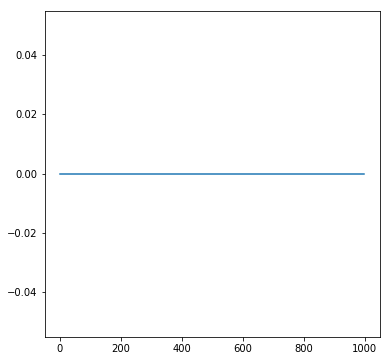

In [15]:
plt.figure(figsize=(6,6))
plt.plot(rewards)
plt.show()
plt.close()

In [14]:
sim.run(render=True, num_steps=num_steps)


SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG


0.0